In [1]:
import sys
sys.path.append('..')

%matplotlib inline
import numpy as np

from fa_kit import FactorAnalysis
from fa_kit import plotting as fa_plotting

In [2]:
def make_random_data(n_samp=10000, n_feat=100):
    """
    make some random data with correlated features
    """
    data = np.random.randn(n_samp, n_feat)
    
    signal_width = 10
    signal_overlap = 2
    step_size = signal_width - signal_overlap
    for i in range(0, data.shape[1], step_size):
        shared_signal = 0.3*np.random.randn(n_samp, 1)
        data[:, i:(i+signal_width)] += shared_signal
    return data

data = make_random_data()

# Set up a factor analysis pipeline

The pipeline requires that you select a method for chooising how many components to retain
* Top N
* Top Pct
* Kaiser's criterion
* Broken Stick

Optionally re-extract components using Principle Axis Factoring

Rotate components
* Varimax
* Quartimax

In [3]:
def run_pipeline(data, retain_method='broken_stick',
    rotation_method='varimax', **kwargs):

    # Set up the factor analysis object, indiate whether the
    # data is a square covariance matrix or a n_samples x n_feat data matrix
    # with the bool `is_covar`

    fa = FactorAnalysis(
        data,
        is_covar=False
        )

    # Extract the components
    fa.extract_components()

    # Calculate how many components to retain
    # You can use any of these methods:
    #   'top_n', 'top_pct', 'kaiser', 'broken_stick'

    fa.find_comps_to_retain(
        method=retain_method,
        **kwargs
        )

    # Once you know how many to retain, re-extract with PAF
    fa.reextract_using_paf()

    # Apply factor rotation
    # Right now there are both 'varimax' and 'quartimax'
    fa.rotate_components(
        method=rotation_method
        )

    # Plot summary
    fig_summary = fa_plotting.full_summary(fa)
    
    return fig_summary

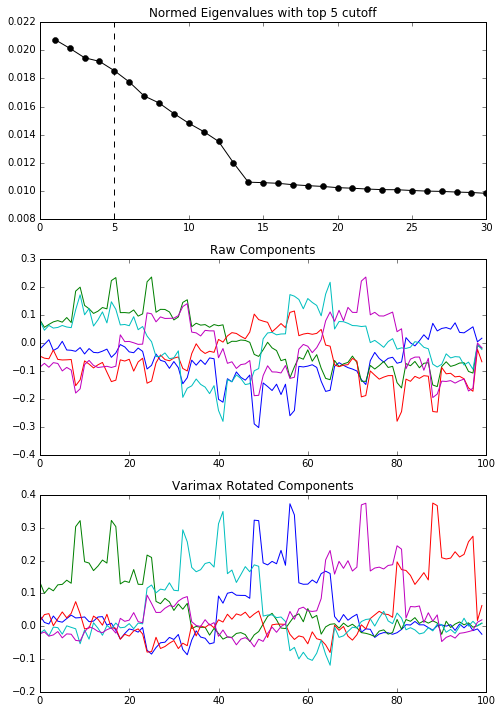

In [4]:
fig = run_pipeline(data, retain_method='top_n', num_keep=5)

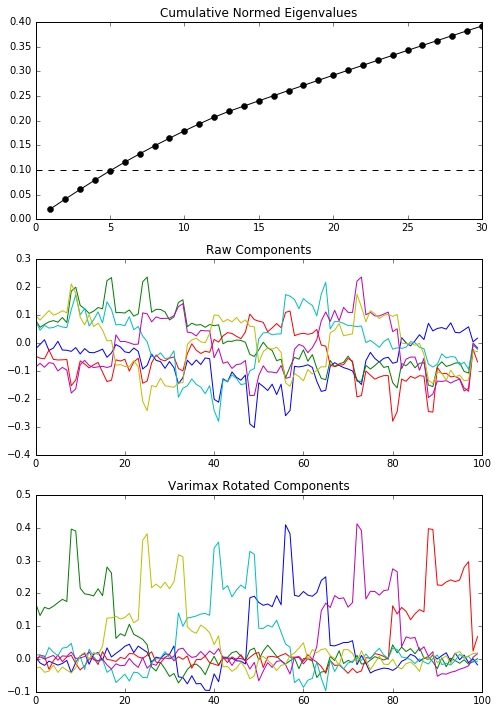

In [5]:
fig = run_pipeline(data, retain_method='top_pct', pct_keep=0.1)

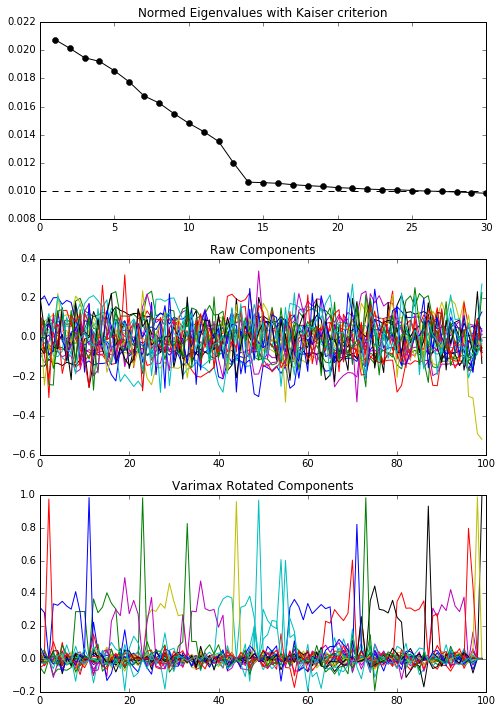

In [6]:
fig = run_pipeline(data, retain_method='kaiser')

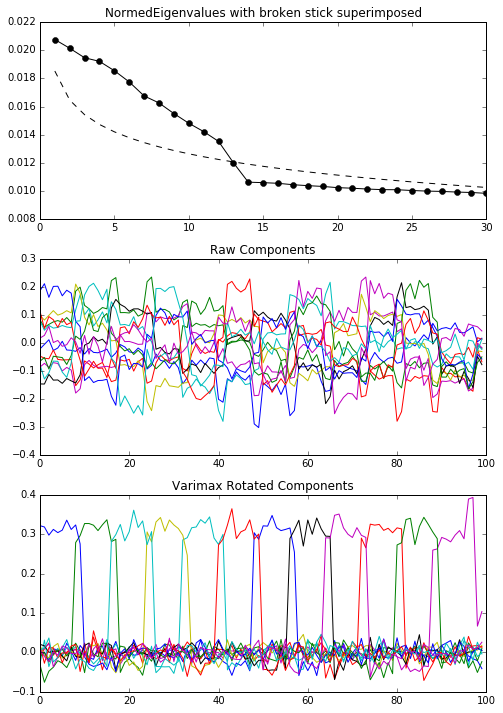

In [7]:
fig = run_pipeline(data, retain_method='broken_stick', rotation_method='varimax')